# David Gamaliel Arcos Bravo
## Proyecto 1: Minería de Texto para Turismo

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import os
import gensim

from utils import *
from openpyxl.utils.dataframe import dataframe_to_rows
from wordcloud import WordCloud
from googletrans import Translator
from deep_translator import GoogleTranslator
from mtranslate import translate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

### 1. (2.5pts) Construya estadísticas básicas respecto a la opinión de cada lugar turístico. Pre-procese y limpie el texto según sus intuiciones y argumente brevemente sobre ello.

Considere scores de 4 a 5 como positivos, calificaciones de 3 como neutros y las de 2
a 1 como negativos. Es interesante ver:

(a) Promedios de calificación por lugar, y desviaciones estándar en los scores

(b) Basado en palabras: longitud promedio de opiniones y desviaciones estándar

(c) Histogramas de edades de opiniones por lugar

(d) Histograma de tipo de visitantes (nacional o internacional) por lugar

(e) Calcular distribuciones en base a Ubicacion	Género Procedencia e Idioma

In [285]:
# translator = Translator()
# def translate(text: str, source_language: str = "auto", target_language: str = "en") -> str:
#    return translator.translate(text, src=source_language, dest=target_language).text

col_names = []

def process_text_column(df_aux, cols):
    for col in cols:
        # replazar acentos,
        val1, val2 = [
            'á', 'é', 'í', 'ó', 'ú', 'ñ', 'ü', 'Á', 'É', 'Í', 'Ó', 'Ú', 'Ñ', 'Ü'
        ], [
            'a', 'e', 'i', 'o', 'u', 'n', 'u', 'a', 'e', 'i', 'o', 'u', 'n', 'u'
        ]
        for a,b in zip(val1, val2):
            df_aux[col] = df_aux[col].str.replace(a, b)
        # Remover ""
        df_aux[col] = df_aux[col].str.replace('"', '')
        # Eliminar caracteres especiales
        df_aux[col] = df_aux[col].str.replace(
            r'[^a-zA-Z0-9\s]', '', regex=True)
        # Convertir a minusculas
        df_aux[col] = df_aux[col].str.lower()
        # Eliminar espacios en blanco
        df_aux[col] = df_aux[col].str.replace(r'\s+', ' ', regex=True)
        # Eliminar espacios en blanco al inicio y al final
        df_aux[col] = df_aux[col].str.strip()
    return df_aux

def excel_to_csv(excel_file, csv_file):
    excel_file = pd.ExcelFile(excel_file)
    sheet_names = excel_file.sheet_names
    for sheet in sheet_names:
        df = excel_file.parse(sheet)
        # Drop null values
        df = df.replace([np.inf, -np.inf, ''], np.nan).dropna()
        # Convertir a int32 columnas con valores numericos
        df = df.astype({'Edad': 'int32', 'Escala': 'int32', 'Número de aportaciones': 'int32'})
        # Renombrar ciertas columnas
        df = df.rename(columns={'Escala': 'Score', 'Nacional ó Internacional': 'Procedencia', 
                                'Número de aportaciones': 'Aportaciones', 'Título de la opinión': 'Titulo', 
                                'Opinión': 'Opinion', 'Género': 'Genero', 'País': 'Pais', 'Calificación': 'Calificacion', })
        # Limpiar el texto
        df = process_text_column(df, ['Titulo', 'Opinion', 'Genero', 'Procedencia', 'Idioma'])
        # Translate both column values to spanish using a public api'))
        # df['Opinión'] = df['Opinión'].apply(lambda x: translate(x, 'es', 'en'))
        df.to_csv(csv_file.format(sheet), index=False, encoding='utf-8')
        
    return sheet_names

excel_file = 'Opiniones_Tripadvisor_nlp_2023.xlsx'
csv_file = '{}.csv'

sheet_names = excel_to_csv(excel_file, csv_file)

In [286]:
df = pd.read_csv(csv_file.format(sheet_names[0]))
col_names = df.columns
df.head()

Genero  Edad    Procedencia Calificacion  Score  Aportaciones  \
0   femenino    64  internacional    Muy bueno      4           175   
1  masculino    59  internacional    Excelente      5           306   
2   femenino    26  internacional    Excelente      5           106   
3  masculino    50  internacional    Excelente      5            62   
4   femenino    55  internacional      Regular      3            59   

                                              Titulo  \
0                                      punto central   
1  the most important church in this colonial tow...   
2                y uno de los simbolos de guanajuato   
3                           beautiful and a must see   
4                                               nice   

                                             Opinion            Pais   Idioma  \
0  basilica muy bien conservada punto central en ...        Colombia  espanol   
1  the basilica guanajuato does not have a cathed...        Colombia   ingles   
2  edificio de la iglesia amarilla es un abigarra...   Corea del Sur  coreano   
3  a must see place in town and very nice to go i...  Estados Unidos   ingles   
4  not particularly impressive but if you like hi...  Estados Unidos   ingles   

  Dispositivo       Fecha  
0       Móvil  2018-05-13  
1          PC  2018-05-08  
2          PC  2018-05-05  
3          PC  2018-05-01  
4          PC  2018-04-29

In [287]:
table = {}
for sheet_name in sheet_names:
    df = pd.read_csv(csv_file.format(sheet_name), encoding='utf-8')
    df['Ubicacion'] = sheet_name
    table[sheet_name] = df

df_all = pd.DataFrame(columns=col_names)
for sheet_name in sheet_names:
    df_all = pd.concat([df_all, table[sheet_name]], ignore_index=True)
df_all['Opinion_Longitud'] = df_all['Opinion'].apply(len)
df_all.head()

Genero Edad    Procedencia Calificacion Score Aportaciones  \
0   femenino   64  internacional    Muy bueno     4          175   
1  masculino   59  internacional    Excelente     5          306   
2   femenino   26  internacional    Excelente     5          106   
3  masculino   50  internacional    Excelente     5           62   
4   femenino   55  internacional      Regular     3           59   

                                              Titulo  \
0                                      punto central   
1  the most important church in this colonial tow...   
2                y uno de los simbolos de guanajuato   
3                           beautiful and a must see   
4                                               nice   

                                             Opinion            Pais   Idioma  \
0  basilica muy bien conservada punto central en ...        Colombia  espanol   
1  the basilica guanajuato does not have a cathed...        Colombia   ingles   
2  edificio de la iglesia amarilla es un abigarra...   Corea del Sur  coreano   
3  a must see place in town and very nice to go i...  Estados Unidos   ingles   
4  not particularly impressive but if you like hi...  Estados Unidos   ingles   

  Dispositivo       Fecha               Ubicacion  Opinion_Longitud  
0       Móvil  2018-05-13  Basilica Colegiata 560               163  
1          PC  2018-05-08  Basilica Colegiata 560               222  
2          PC  2018-05-05  Basilica Colegiata 560               201  
3          PC  2018-05-01  Basilica Colegiata 560               108  
4          PC  2018-04-29  Basilica Colegiata 560                97

In [288]:
df_group = df_all.groupby([ 'Ubicacion', 'Genero', 'Procedencia', 'Idioma']).agg(
                            {'Edad': ['mean', 'std'], 'Score': ['mean', 'std'],
                            'Aportaciones': ['mean', 'std'],
                            'Opinion_Longitud': ['mean', 'std']})
df_group = df_group.replace([np.inf, -np.inf], np.nan).dropna()
df_group.to_csv('Statistics.csv', index=True, encoding='utf-8')
df_group

Edad  \
                                                                      mean   
Ubicacion                     Genero    Procedencia   Idioma                 
Alhóndiga 930                 femenino  internacional espanol    37.878788   
                                                      frances    47.333333   
                                                      ingles     46.884615   
                                                      japones    50.000000   
                                                      portugues  46.000000   
...                                                                    ...   
Universidad de Guanajuato 900 masculino internacional italiano   47.571429   
                                                      japones    53.230769   
                                                      portuges   38.352941   
                                        nacional      espanol    37.371648   
                                                      ingles     43.076923   

                                                                            \
                                                                       std   
Ubicacion                     Genero    Procedencia   Idioma                 
Alhóndiga 930                 femenino  internacional espanol    10.882203   
                                                      frances    11.015141   
                                                      ingles     14.102575   
                                                      japones    19.798990   
                                                      portugues  29.698485   
...                                                                    ...   
Universidad de Guanajuato 900 masculino internacional italiano   17.357584   
                                                      japones    14.207708   
                                                      portuges   16.003676   
                                        nacional      espanol    13.134357   
                                                      ingles     10.835601   

                                                                    Score  \
                                                                     mean   
Ubicacion                     Genero    Procedencia   Idioma                
Alhóndiga 930                 femenino  internacional espanol    4.454545   
                                                      frances    4.666667   
                                                      ingles     4.435897   
                                                      japones    4.000000   
                                                      portugues  5.000000   
...                                                                   ...   
Universidad de Guanajuato 900 masculino internacional italiano   4.571429   
                                                      japones    3.846154   
                                                      portuges   4.529412   
                                        nacional      espanol    4.681992   
                                                      ingles     4.615385   

                                                                           \
                                                                      std   
Ubicacion                     Genero    Procedencia   Idioma                
Alhóndiga 930                 femenino  internacional espanol    0.711113   
                                                      frances    0.577350   
                                                      ingles     0.675926   
                                                      japones    1.414214   
                                                      portugues  0.000000   
...                                                                   ...   
Universidad de Guanajuato 900 masculino internacional italiano   0.534522   
                                   

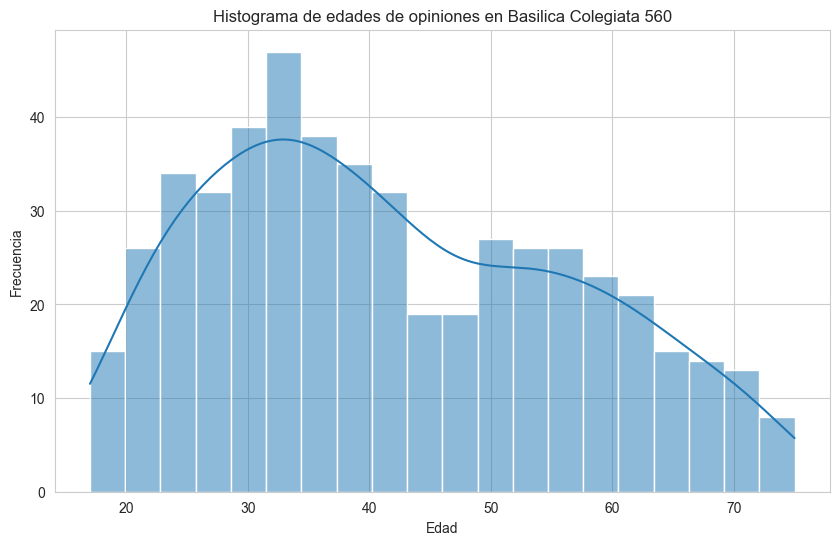

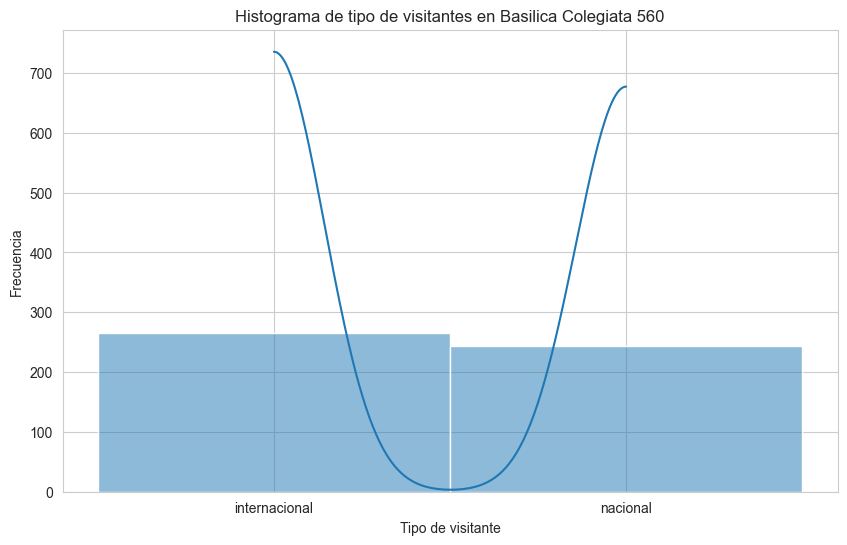

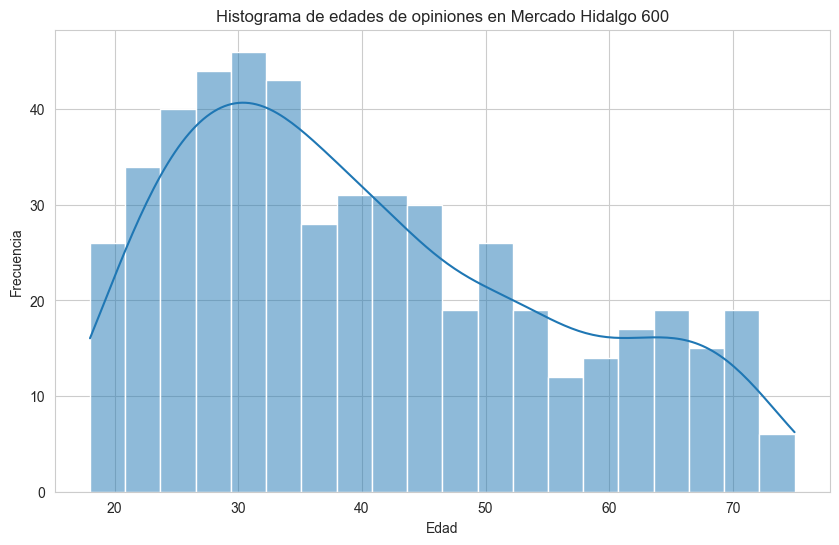

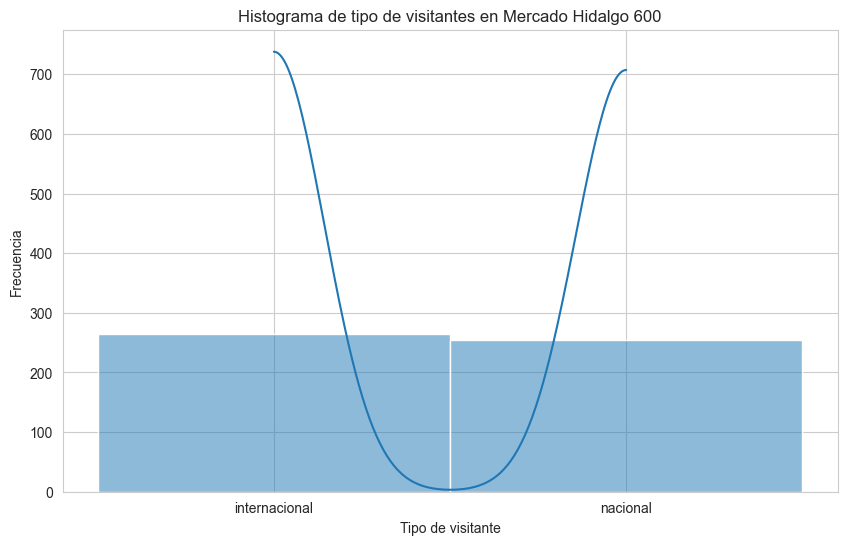

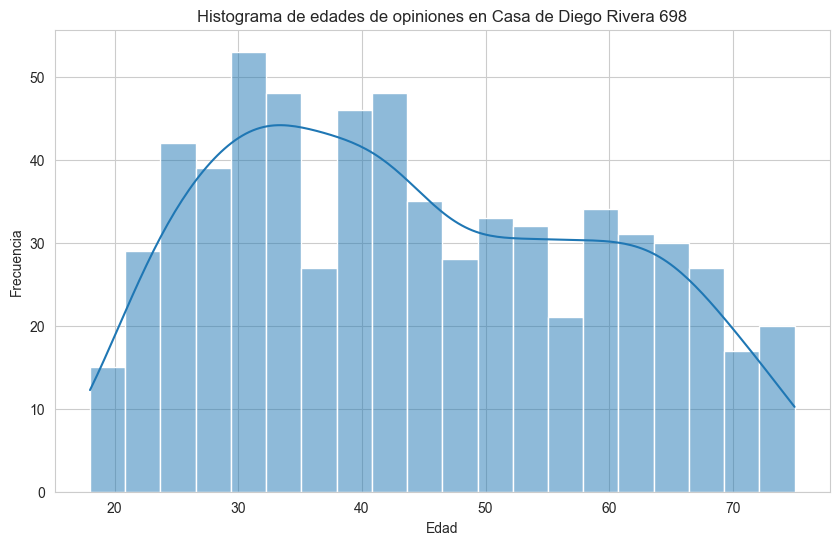

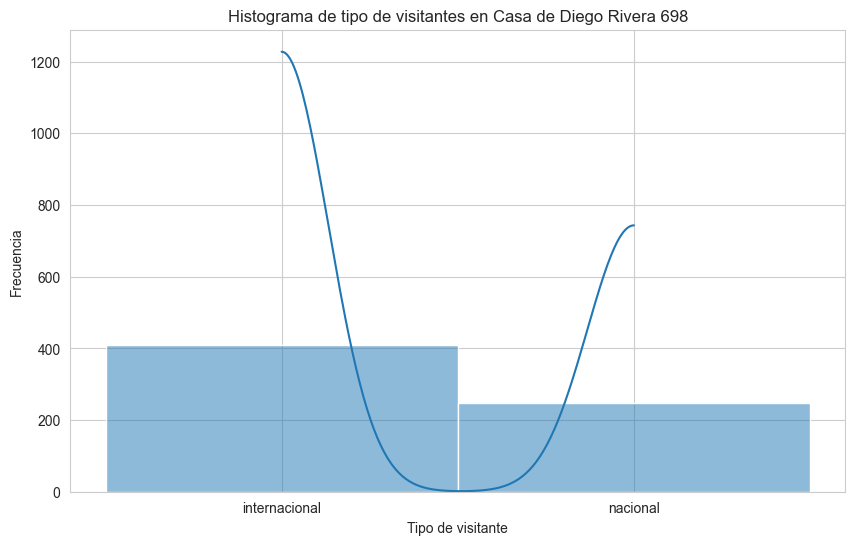

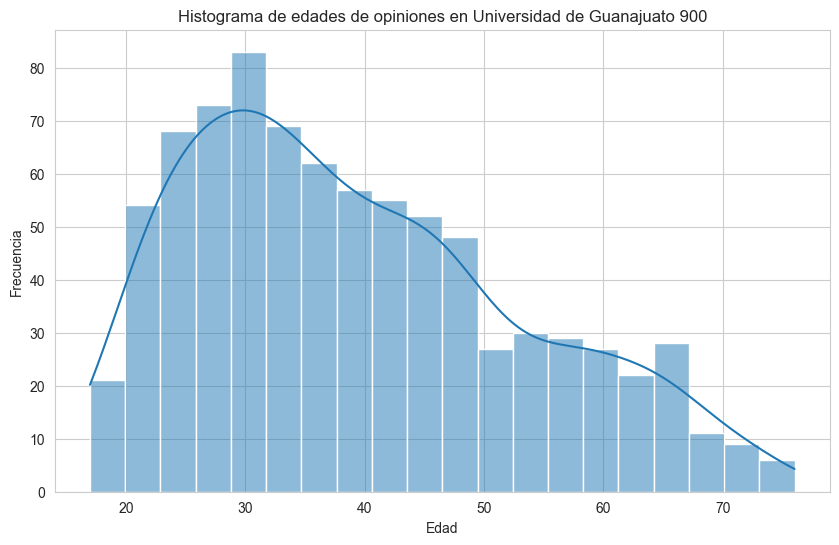

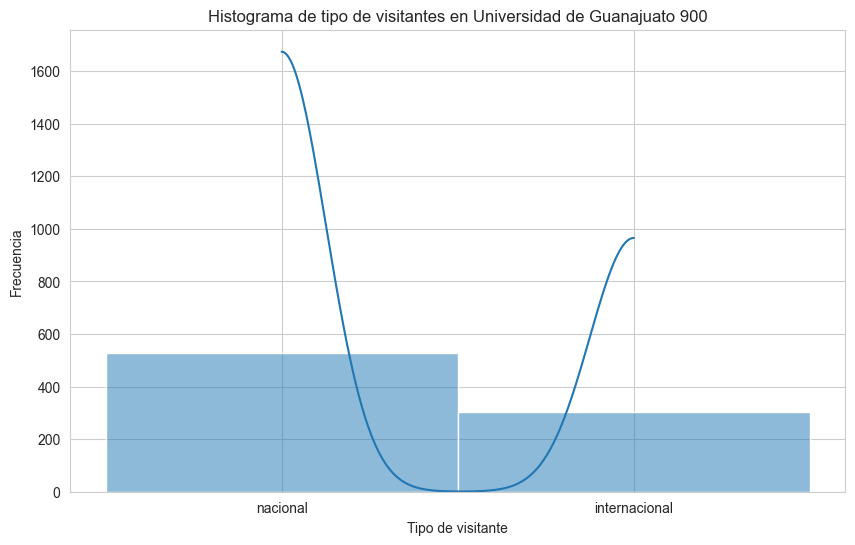

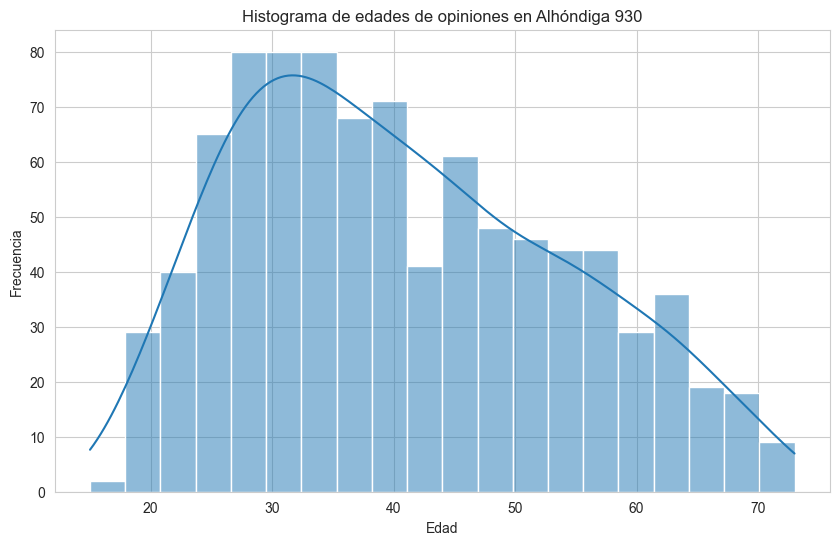

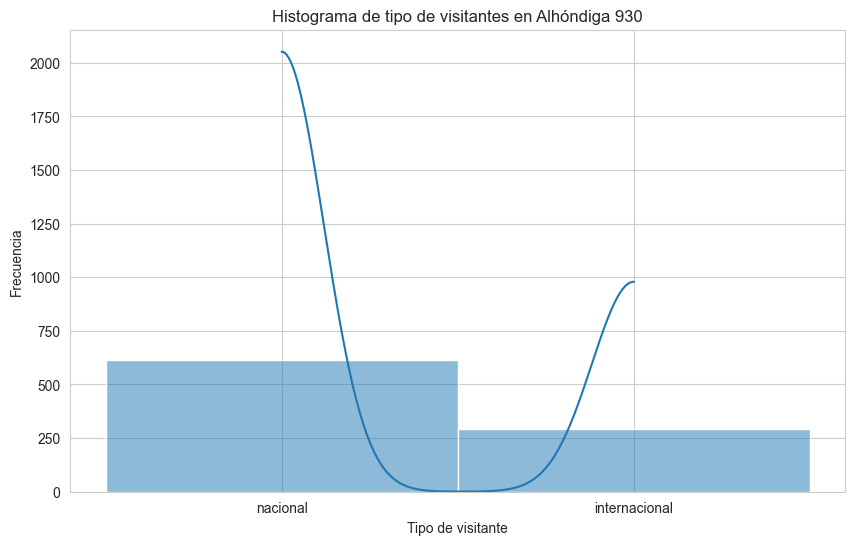

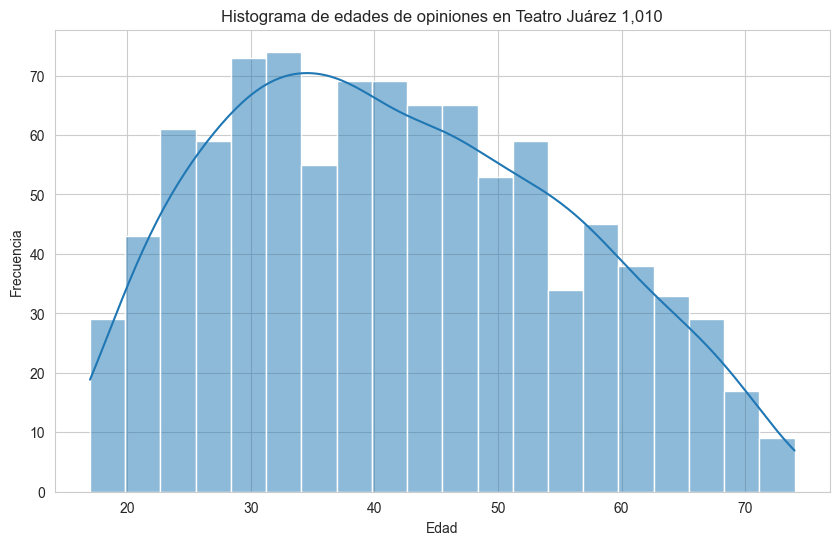

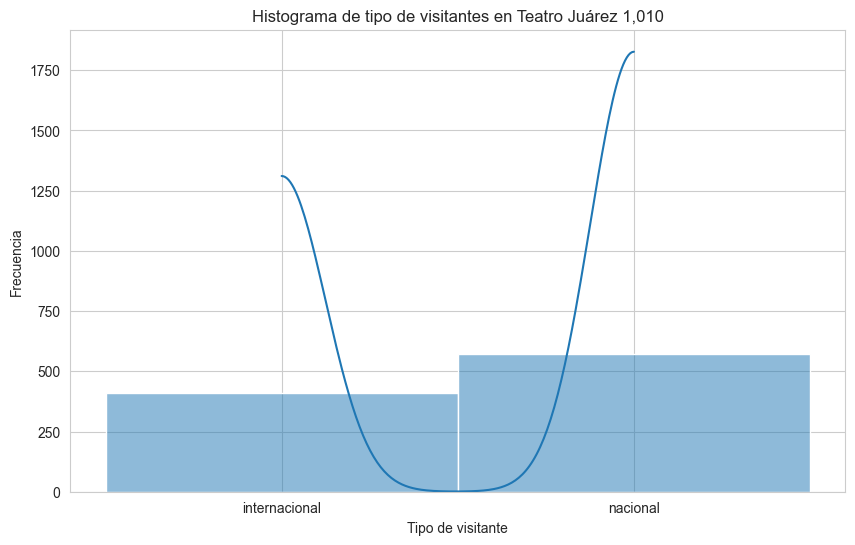

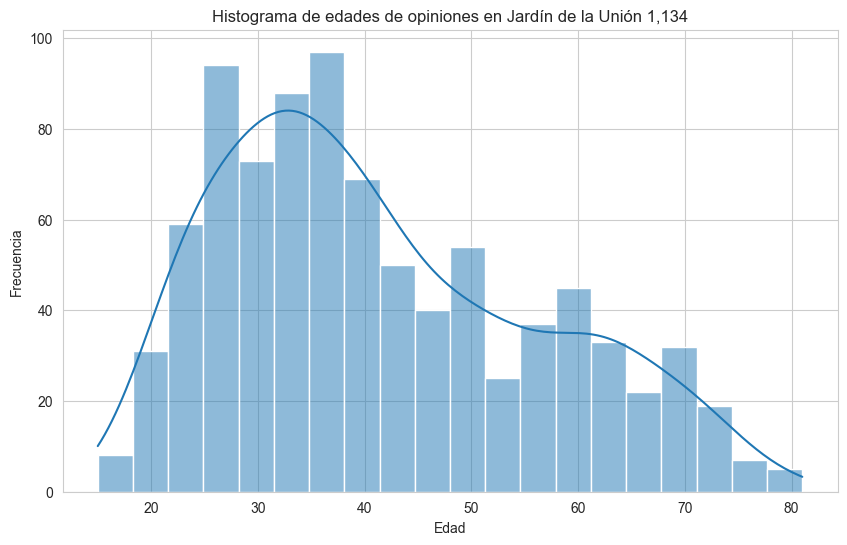

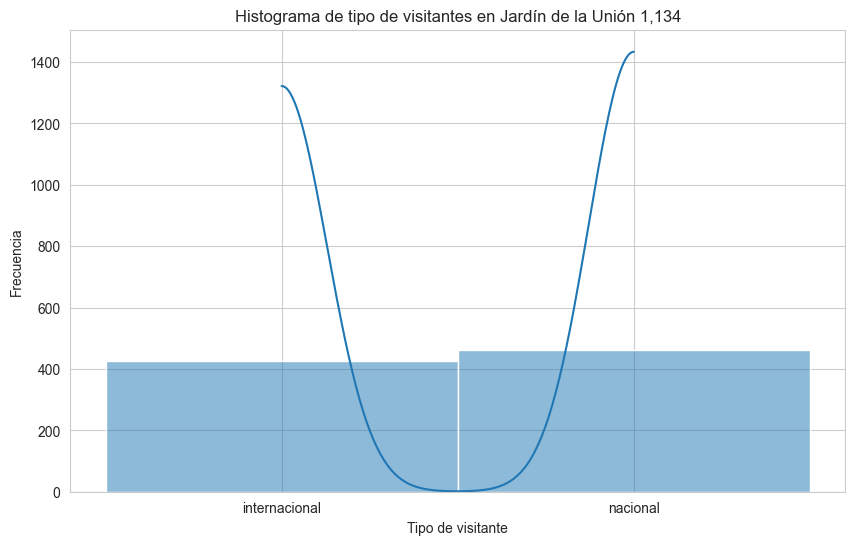

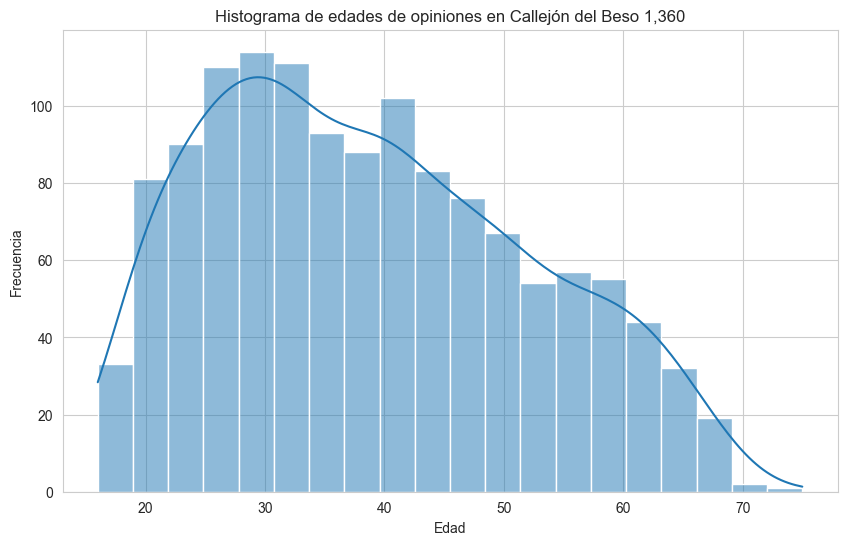

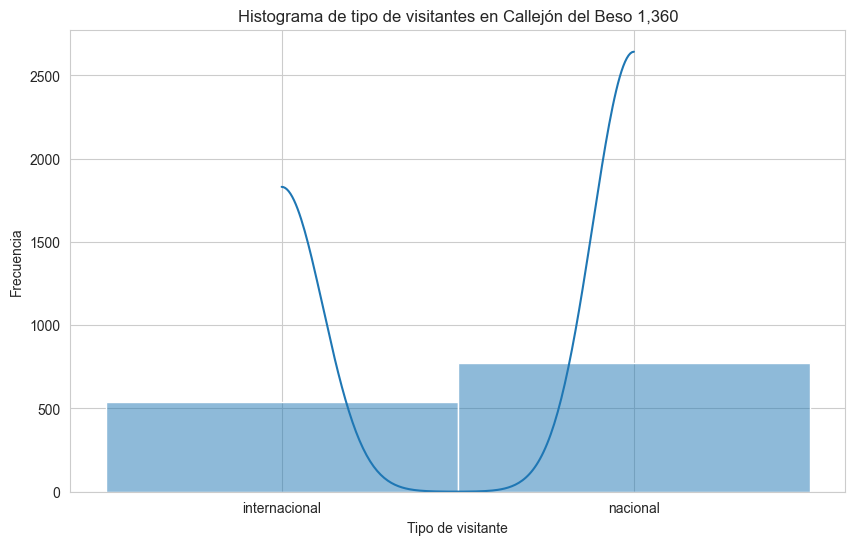

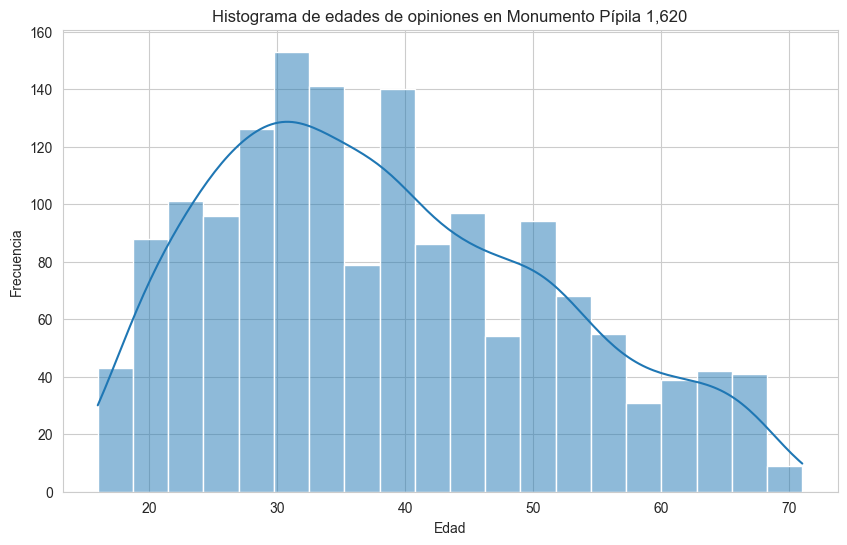

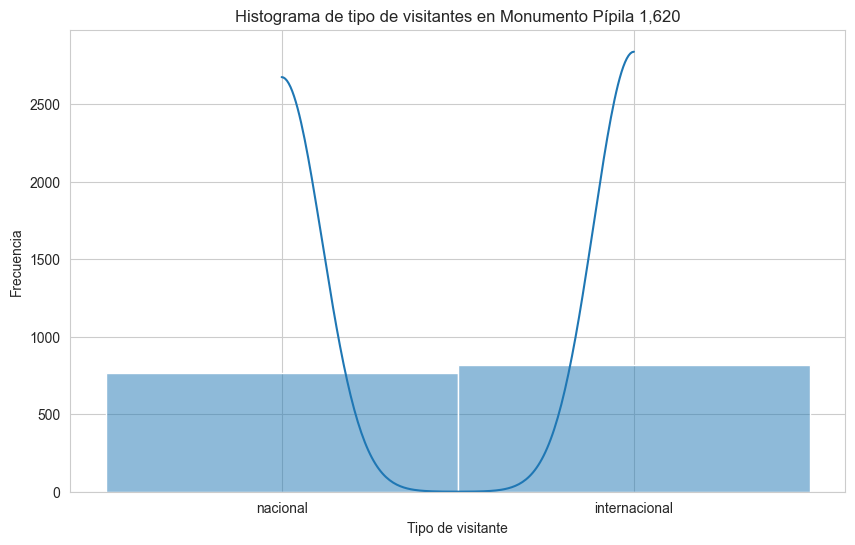

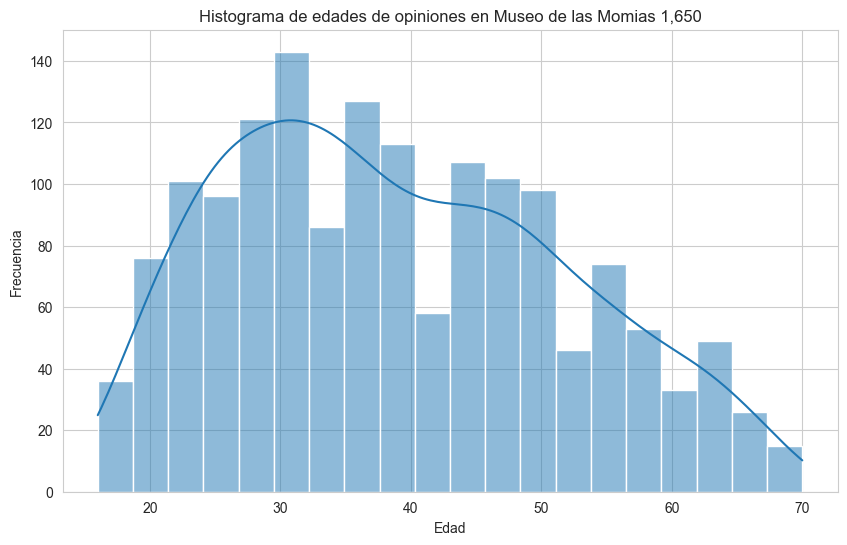

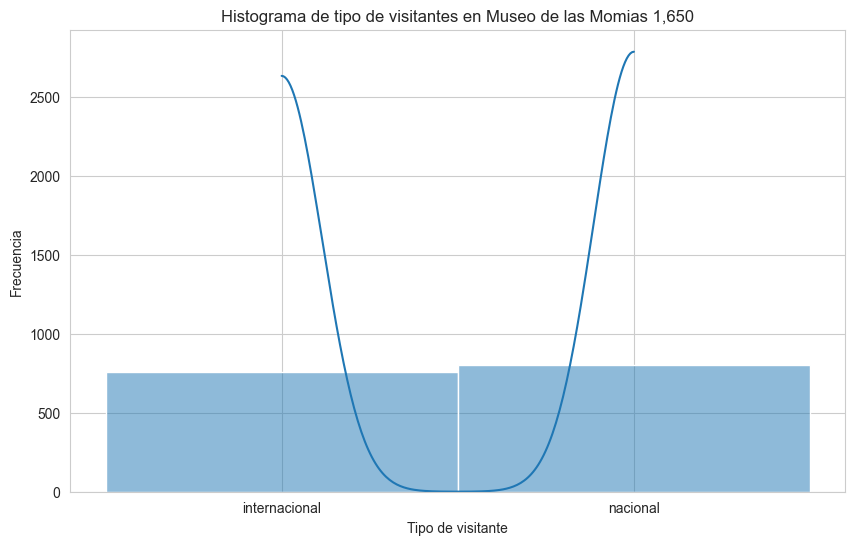

In [289]:
def plot_hist(df, col, title, xlabel, ylabel, bins):
    sb.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    sb.histplot(data=df, x=col, bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

for sheet_name in sheet_names:
    # (c) Histogramas de edades de opiniones por lugar
    df_aux = df_all[df_all['Ubicacion'] == sheet_name]
    plot_hist(df_aux, 'Edad', f'Histograma de edades de opiniones en {sheet_name}', 'Edad', 'Frecuencia', bins=20)
    # (d) Histograma de tipo de visitantes (nacional o internacional) por lugar
    plot_hist(df_aux, 'Procedencia', f'Histograma de tipo de visitantes en {sheet_name}', 'Tipo de visitante', 'Frecuencia', bins=2)

### 2. (2.5pts) Utilizando una estrategia de feature selection (se sugiere X2 o ganancia de información) visualice con word_cloud ( https://amueller.github.io/word_cloud/ ) nubes de palabras el top k (se sugiere 50) de palabras más relevantes para cada uno de los 10 lugares. Note que serán 10 nubes, una por lugar.

In [290]:
def plot_word_cloud(K_Best_words, title):
    wordcloud = WordCloud(width=1000, height=1000, background_color="black").generate(K_Best_words)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Nube de palabras de opiniones en {title}')
    plt.show()
    plt.close()

def generate_cloud(X_tfidf,y,k, title):
    # Use tfidf on X
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(X_tfidf)
    # Select top 50 features
    selector = SelectKBest(chi2, k=min(k,X_tfidf.shape[1]))
    selector.fit(X_tfidf, y)
    # Get idxs of columns to keep
    idxs_selected = selector.get_support(indices=True)
    K_Best_words = ''
    for idx in idxs_selected:
        K_Best_words += tfidf_vectorizer.get_feature_names_out()[idx] + ' '
    plot_word_cloud(K_Best_words, title)

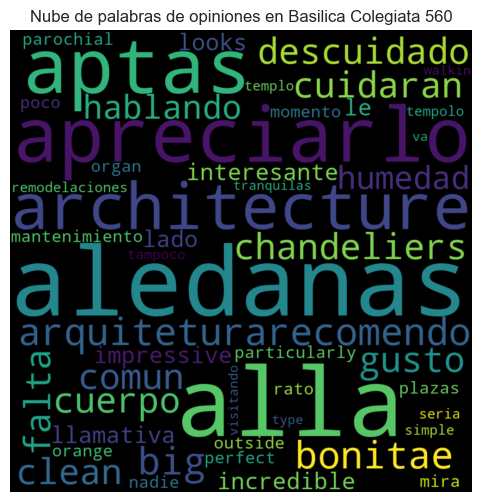

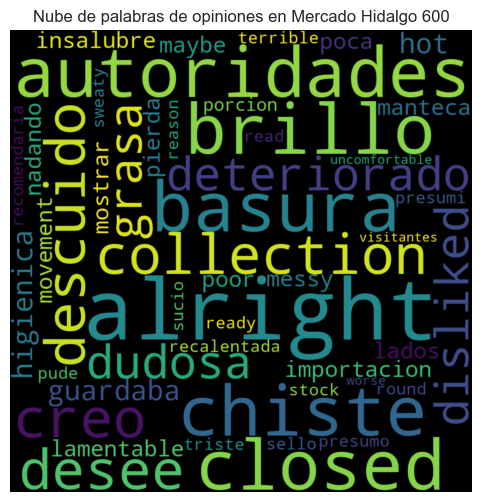

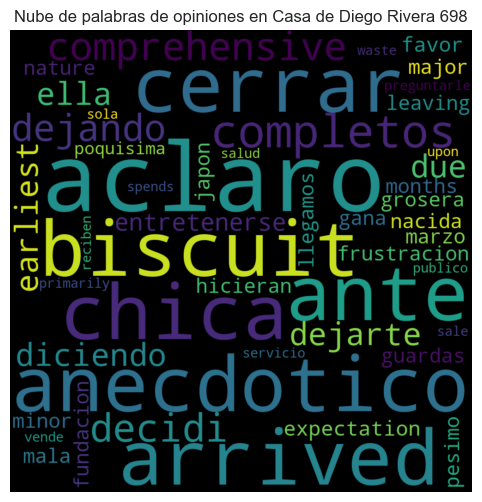

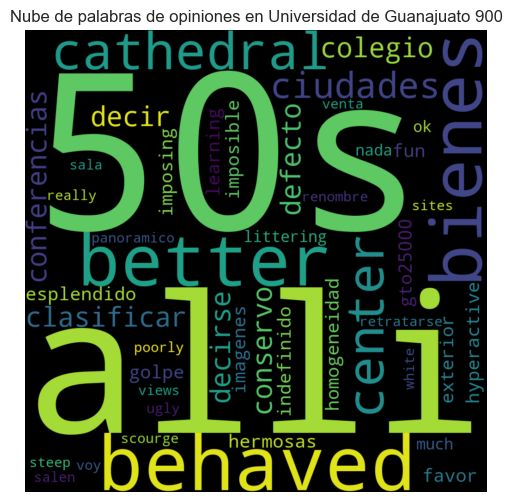

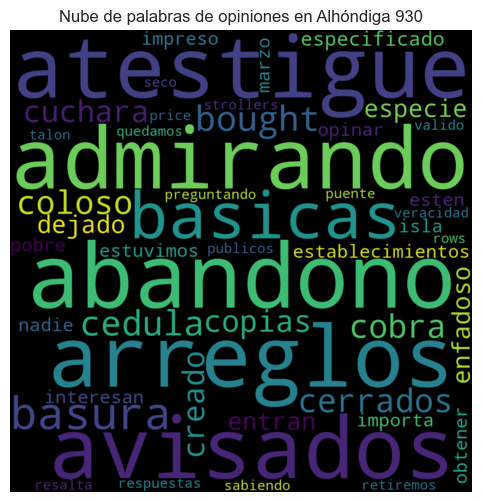

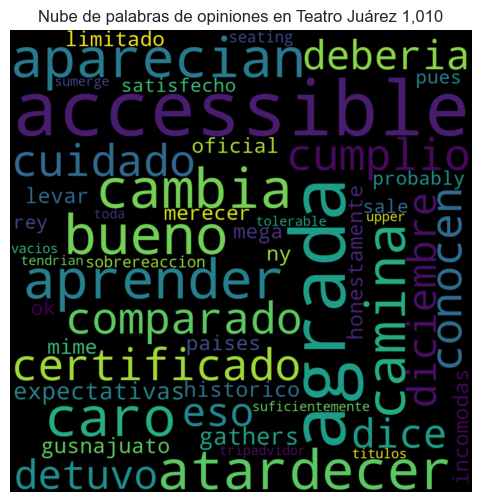

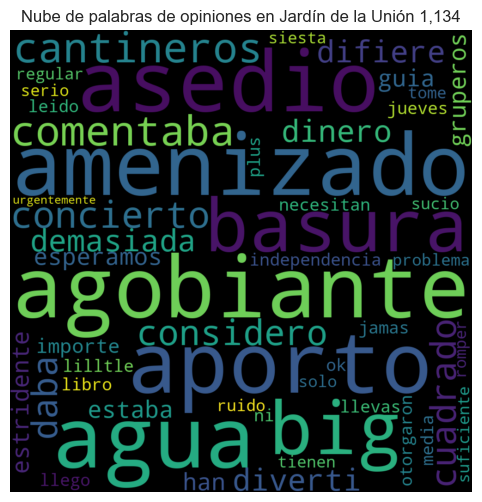

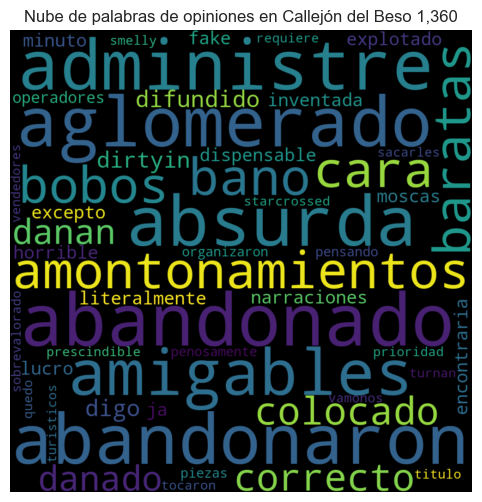

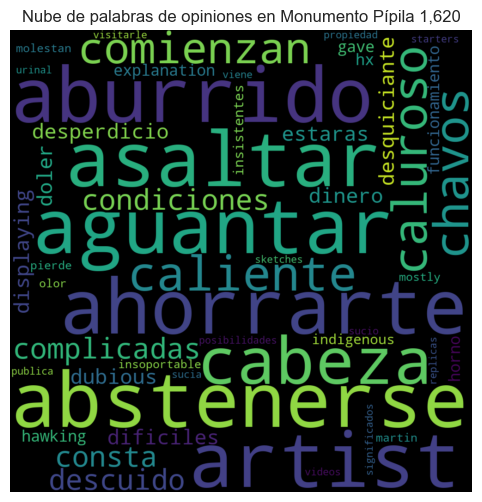

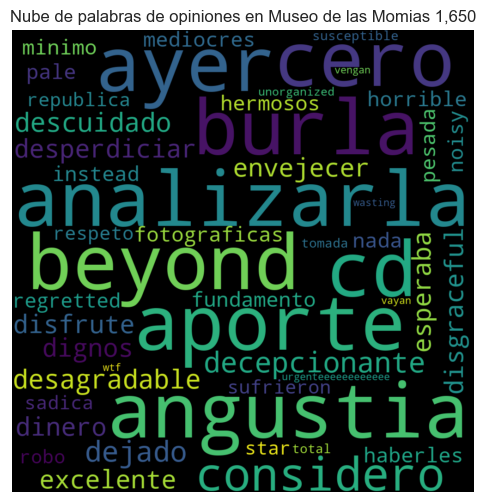

In [291]:
for sheet_name in sheet_names:
    df_aux = df_all[df_all['Ubicacion'] == sheet_name].copy()
    X = df_aux['Opinion']
    y = df_aux['Score']
    y = y.astype(int)
    generate_cloud(X,y,50,sheet_name)

### 3. (15pts) Para cada uno de los 10 sitios turísticos, haga un descubrimiento automático de los 3 tópicos con LSA (investiga, estudia y aprende por su cuenta LSA) más relevantes y 10 palabras contenidas en cada tópico de cada uno de los siguientes subgrupos:
(a) Hombres

(b) Mujeres

(c) Turistas Nacionales

(d) Turistas Internacionales

(e) Jovénes (elige un rango de edad interesante con base en sus estadísticas)

(f) Mayores (elige un rango de edad interesante con base en sus estadísticas)

Antes de aplicar LSA, asegúrese de hacerlo sobre una matriz lo más grande posible
(para su hardware) de TFIDF Normalizada a L2. Note que para cada sitio turístico deberá saber cuales son los 3 temas de interés y sus palabras, para cada uno de es-
tos subgrupos. Como sugerencia puede usar la función TruncatedSVD de sklearnt para obtener la descomposición de matrices como se sugiere en el siguiente video
para implementar LSA: https://www.youtube.com/watch?v=hB51kkus-Rc. También
podría llevar a cabo svd con numpy. Otra sugerencia para LSA es investigar a hacerlo
con la librería gensim de python.

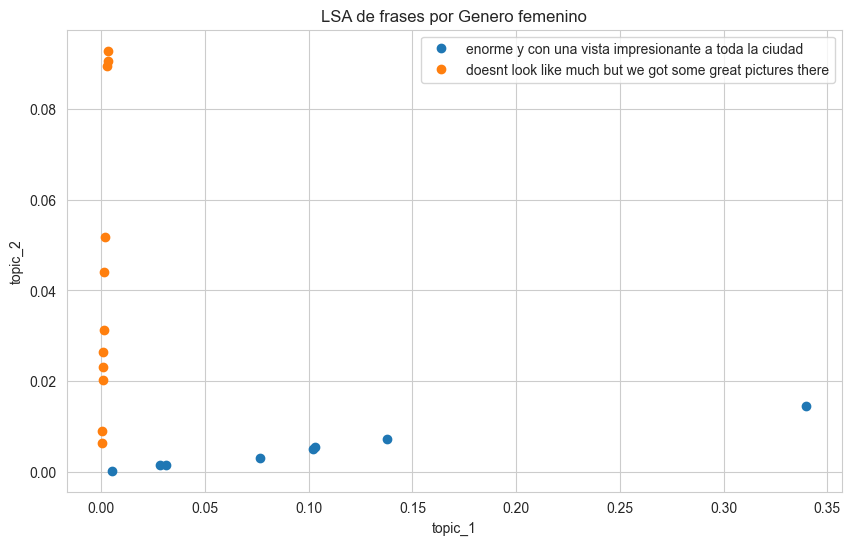

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


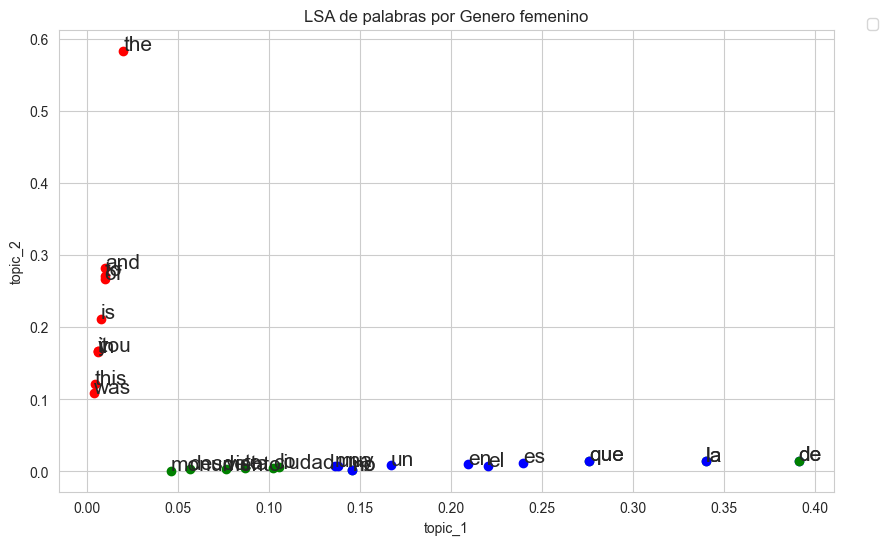

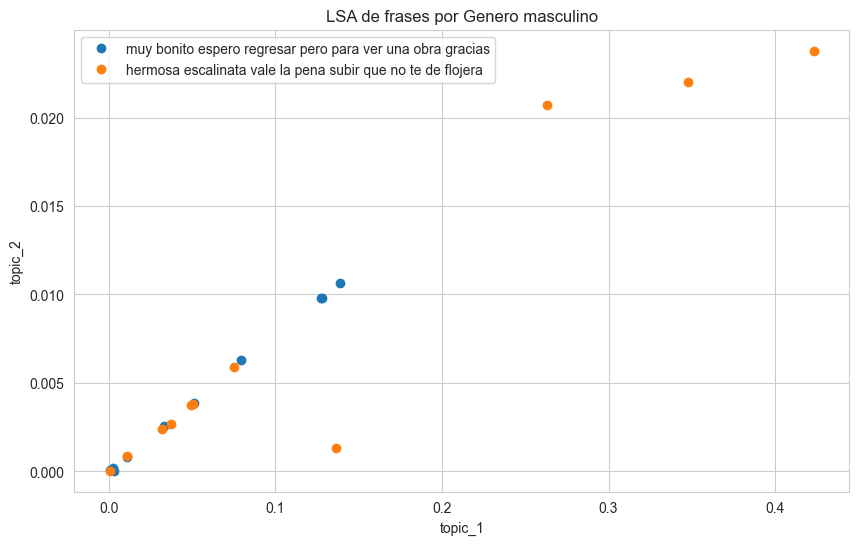

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


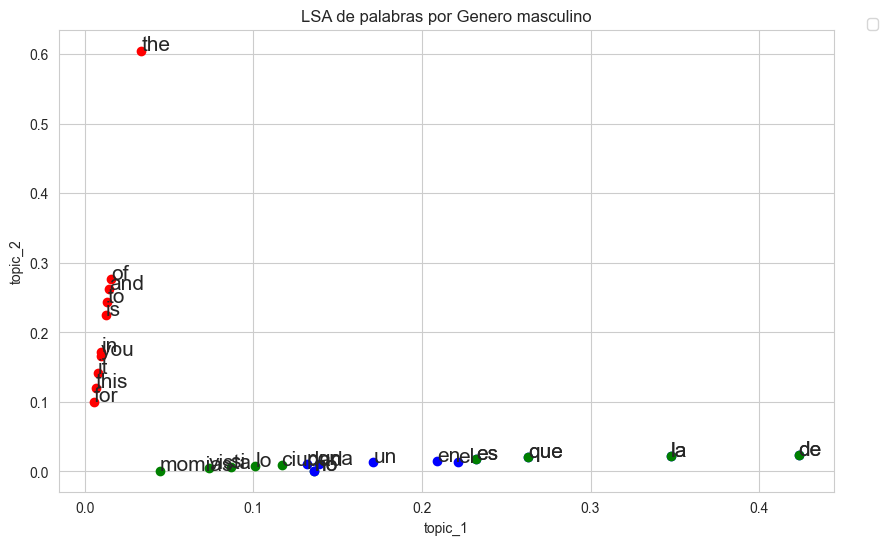

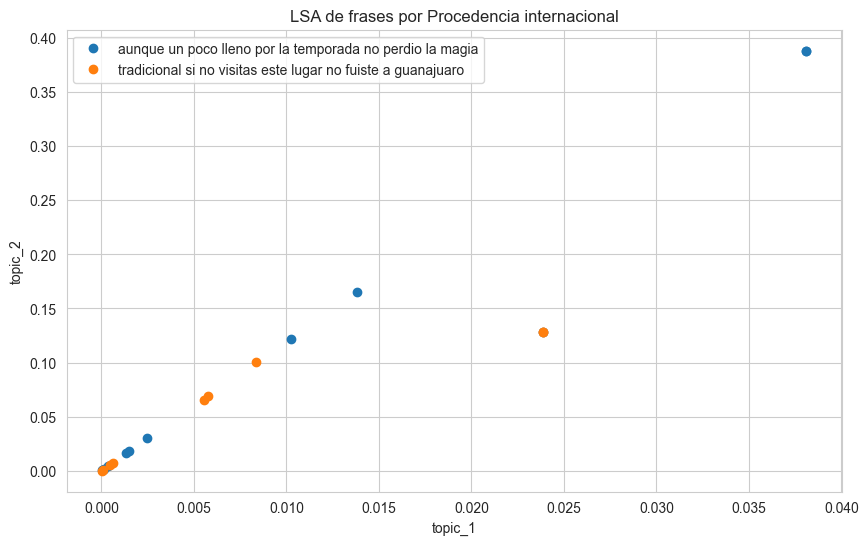

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


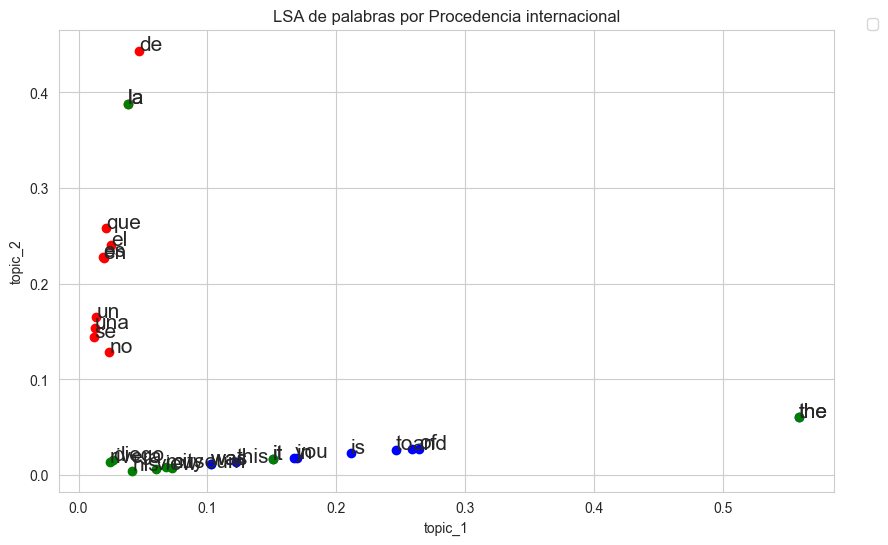

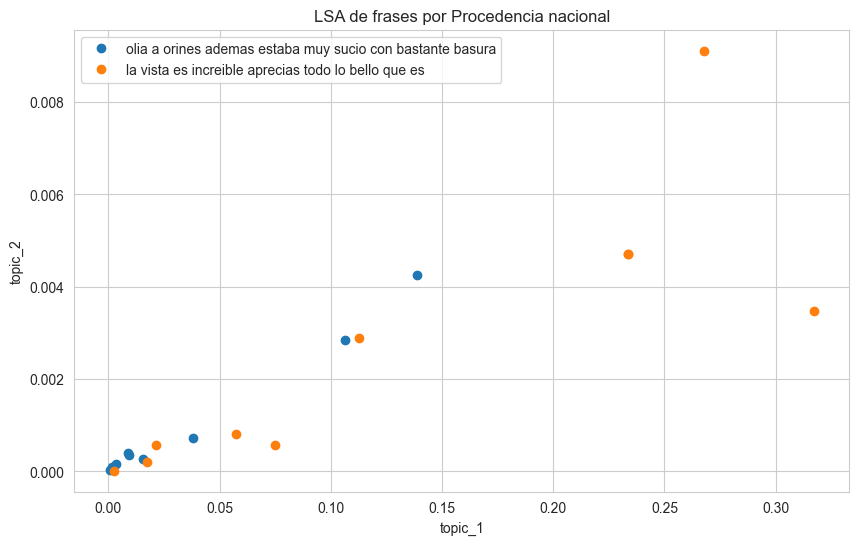

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


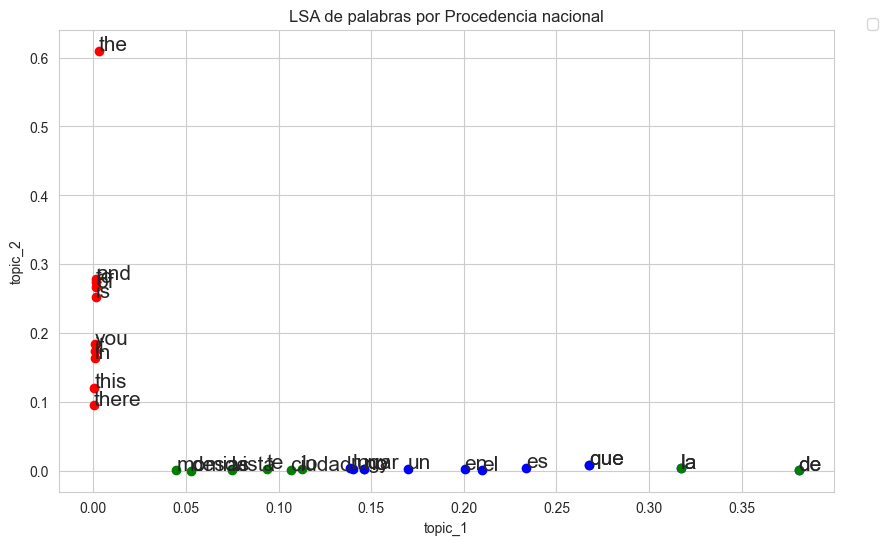

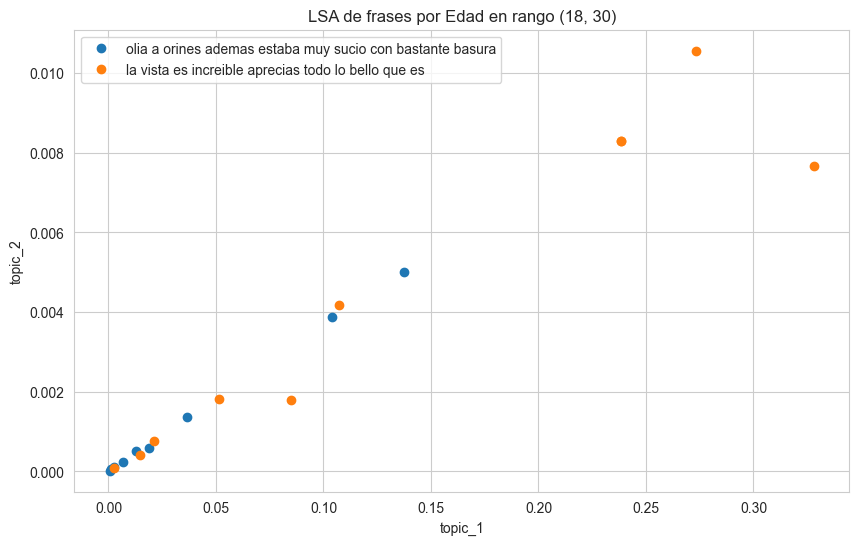

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


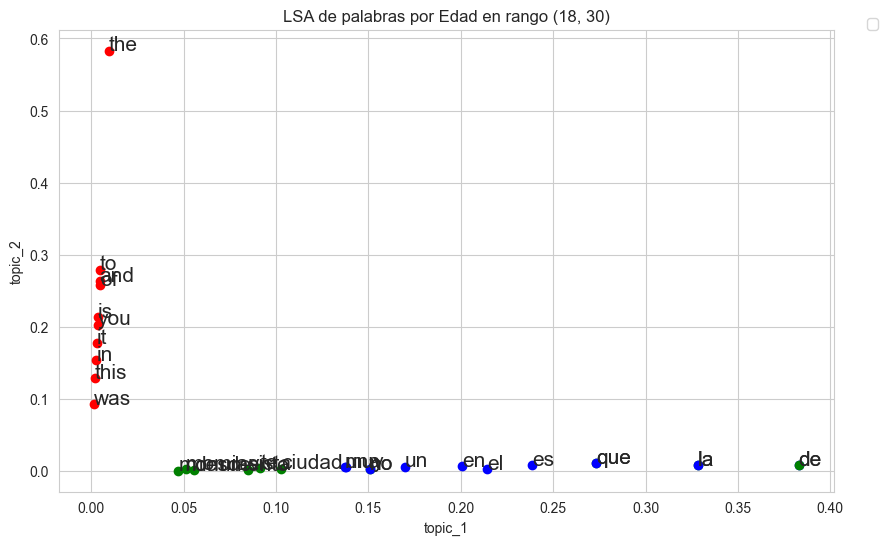

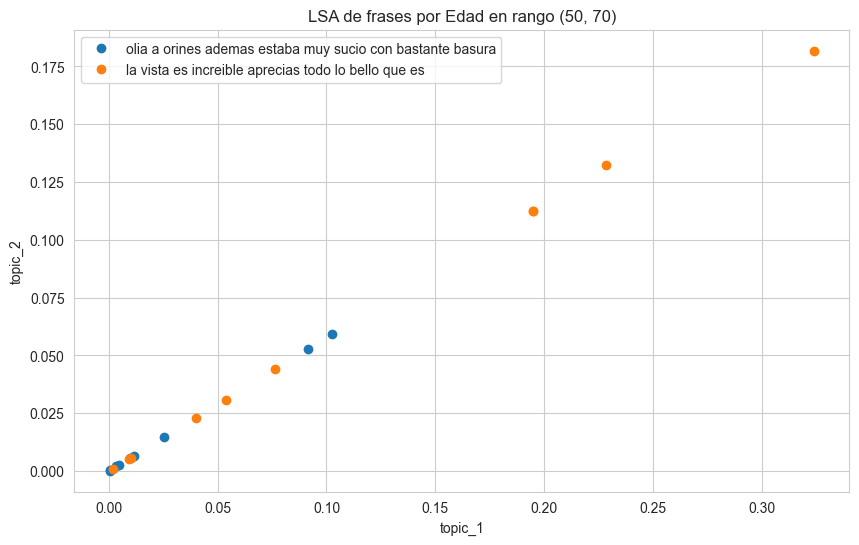

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


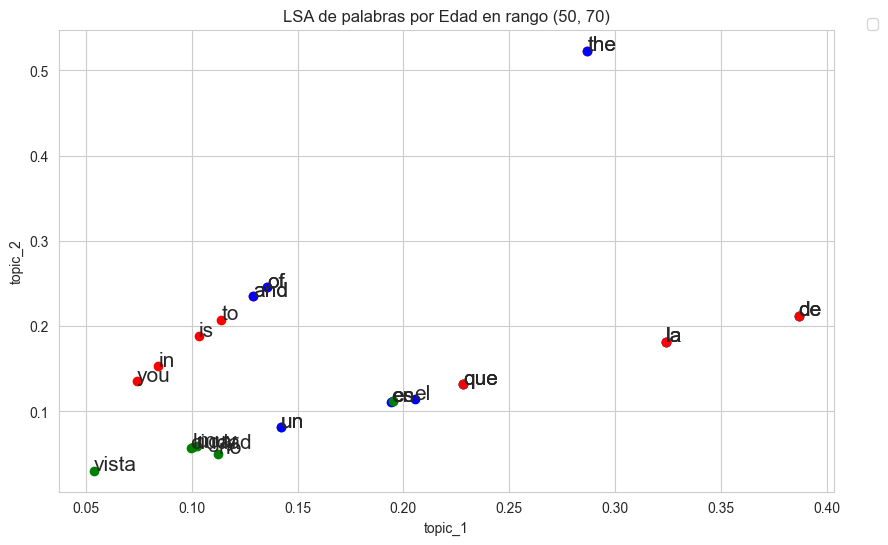

In [292]:
def apply_lsa(df_aux):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_aux['Opinion'].copy())
    X.todense()
    svd = TruncatedSVD(n_components=3)
    lsa = svd.fit_transform(X)
    df_lsa = pd.DataFrame(lsa, columns=['topic_1', 'topic_2', 'topic_3'])
    df_lsa['Opinion'] = df_aux['Opinion'].values
    df_lsa['Score'] = df_aux['Score'].values
    dictionary = vectorizer.get_feature_names_out()
    encoding_matrix = pd.DataFrame(svd.components_.T,
                                    index=dictionary,
                                    columns=['topic_1', 'topic_2', 'topic_3'])
    encoding_matrix = np.abs(encoding_matrix)
    encoding_matrix_by_topic1 = encoding_matrix.sort_values(by=['topic_1'], ascending=False)
    encoding_matrix_by_topic2 = encoding_matrix.sort_values(by=['topic_2'], ascending=False)
    encoding_matrix_by_topic3 = encoding_matrix.sort_values(by=['topic_3'], ascending=False)
    return df_lsa, encoding_matrix_by_topic1, encoding_matrix_by_topic2, encoding_matrix_by_topic3

def plot_lsa(df_lsa, title):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_lsa['topic_1'].values, df_lsa['topic_2'].values, df_lsa['topic_3'].values) #  c=df_lsa['Score'], cmap='viridis')
    ax.set_xlabel('topic_1')
    ax.set_ylabel('topic_2')
    ax.set_zlabel('topic_3')
    plt.title(f'LSA de opiniones por {title}')
    plt.legend()
    plt.show()
    plt.close(fig)

def plot_phrases(phrases, mat, title):
    fig = plt.figure(figsize=(10, 6))
    for phrase in phrases:
        st = phrase
        phrase = phrase.split()
        phrase = [word for word in phrase if word in mat.index]
        phrase = mat.loc[phrase]
        plt.plot(phrase['topic_1'].values, phrase['topic_2'].values, 'o', label=f'{st}')
    plt.xlabel('topic_1')
    plt.ylabel('topic_2')
    plt.title(f'LSA de frases por {title}')
    plt.legend()
    plt.show()
    plt.close(fig)

def plot_top_words(mat1, mat2, mat3, k, title):
    fig = plt.figure(figsize=(10, 6))
    fnt_sz = 15
    padd = 0.0
    for i in range(k):
        plt.plot(mat1.iloc[i]['topic_1'], mat1.iloc[i]['topic_2'], 'o', color='blue')
        plt.text(mat1.iloc[i]['topic_1'], mat1.iloc[i]['topic_2'], mat1.index[i], fontsize=fnt_sz, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.0, pad=padd))
        plt.plot(mat2.iloc[i]['topic_1'], mat2.iloc[i]['topic_2'], 'o', color='red')
        plt.text(mat2.iloc[i]['topic_1'], mat2.iloc[i]['topic_2'], mat2.index[i], fontsize=fnt_sz,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0, pad=padd))
        plt.plot(mat3.iloc[i]['topic_1'], mat3.iloc[i]['topic_2'], 'o', color='green')
        plt.text(mat3.iloc[i]['topic_1'], mat3.iloc[i]['topic_2'], mat3.index[i], fontsize=fnt_sz,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.0, pad=padd))
    plt.xlabel('topic_1')
    plt.ylabel('topic_2')
    plt.title(f'LSA de palabras por {title}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='lower center', borderaxespad=0.)
    plt.show()
    plt.close(fig)

values = ['Genero', 'Procedencia']
for value in values:
    unique_values = df_all[value].unique()
    for unique_value in unique_values:
        df_aux = df_all[df_all[value] == unique_value].copy()
        df_lsa, encoding_matrix_by_topic1, encoding_matrix_by_topic2, encoding_matrix_by_topic3 = apply_lsa(df_aux)
        # phrases = df_aux['Opinion'].sample(3).values
        phrases = df_aux['Opinion'].loc[df_aux['Opinion'].str.len().between(50, 60)].sample(2).values
        title = value + ' ' + unique_value
        plot_phrases(phrases, encoding_matrix_by_topic1, title)
        plot_top_words(encoding_matrix_by_topic1, encoding_matrix_by_topic2, encoding_matrix_by_topic3, 10, title)

age_ranges = [(18, 30), (50, 70)]
for age_range in age_ranges:
    title = 'Edad en rango ' + str(age_range)
    df_aux = df_all[df_all['Edad'].between(age_range[0], age_range[1])].copy()
    df_lsa, encoding_matrix_by_topic1, encoding_matrix_by_topic2, encoding_matrix_by_topic3 = apply_lsa(df_aux)
    plot_phrases(phrases, encoding_matrix_by_topic1, title)
    plot_top_words(encoding_matrix_by_topic1, encoding_matrix_by_topic2, encoding_matrix_by_topic3, 10, title)

plt.close('all')

### 4. (5pts) Para cada uno de los 10 sitios turísticos, haga una nube de palabras que muestre las palabras más asociadas a sus opiniones negativas utilizando X 2. Puede usar funciones de sklearn.

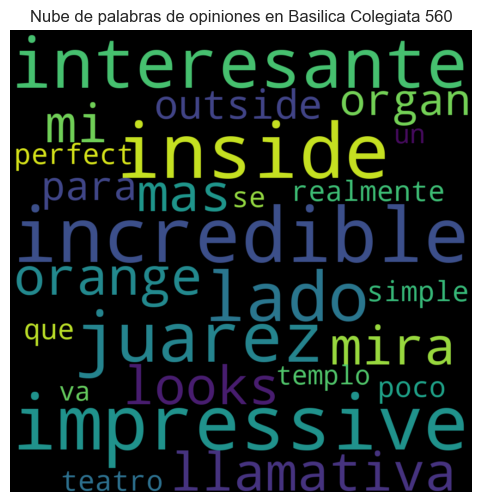

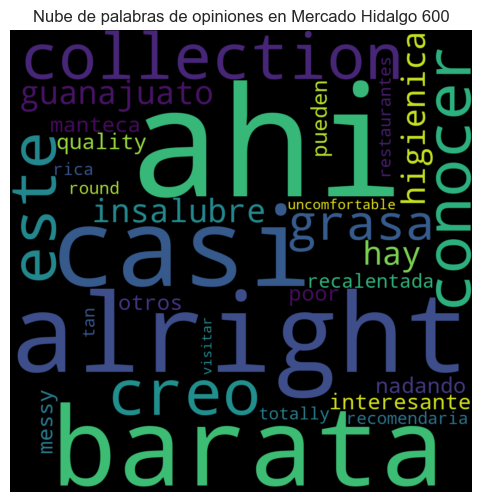

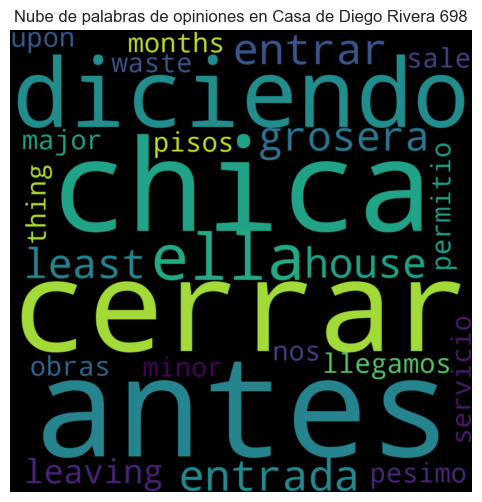

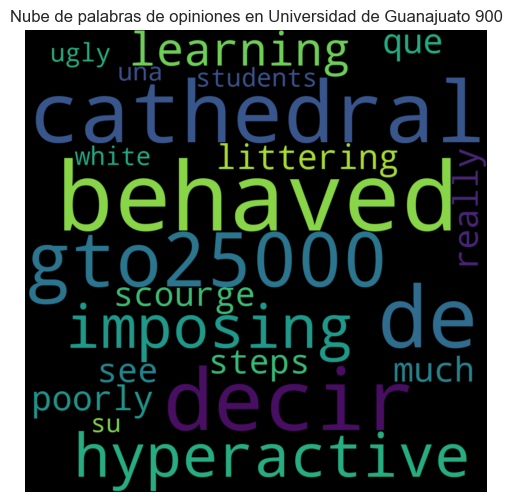

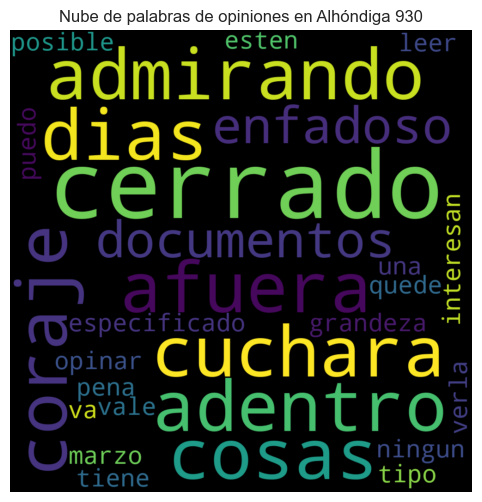

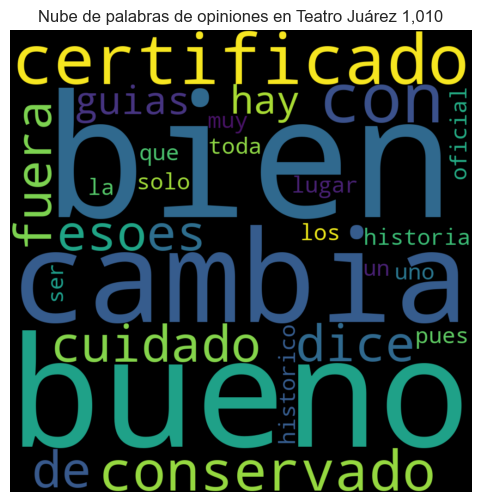

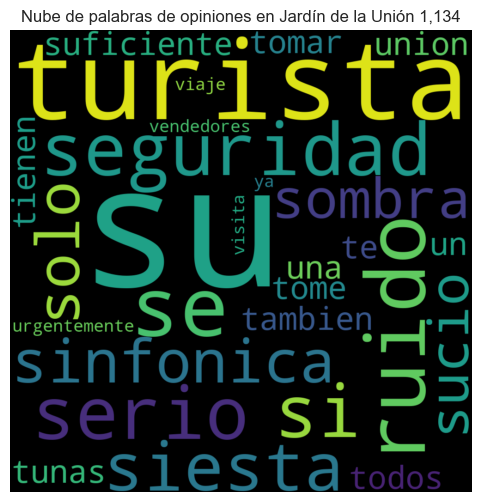

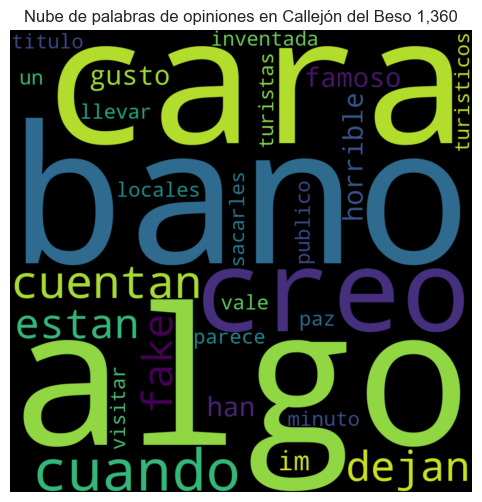

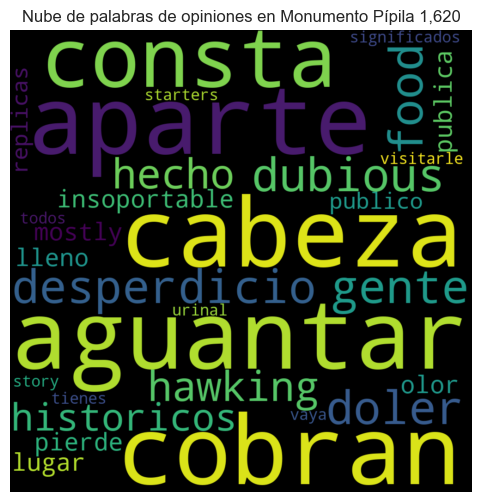

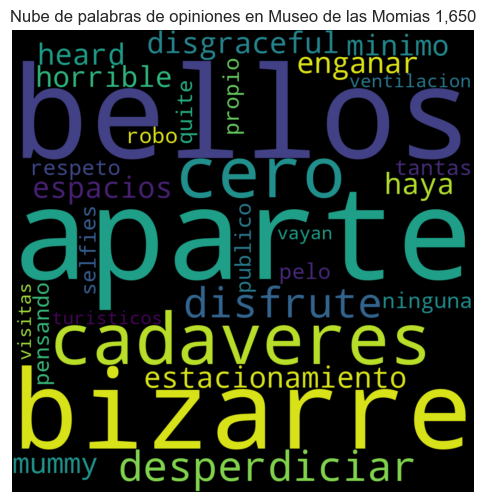

In [293]:
for sheet_name in sheet_names:
    df_aux = df_all[df_all['Ubicacion'] == sheet_name].copy()
    df_aux = df_aux[df_aux['Score'] < 3]
    X = df_aux['Opinion']
    y = df_aux['Score']
    y = y.astype(int)
    generate_cloud(X,y,30,sheet_name)

### 5. (15pts) Para cada uno de los 10 sitios turísticos construya tres Bolsas de Palabras de la siguiente manera: 

i) 1000 términos con mayor peso tfidf, 

ii) 2000 bigramas con mayor tfidf

iii) 1000 trigramas con mayor tfidf. 

Luego concatene las tres representaciones que fueron calculadas de forma independiente, con sus propios tfidfs según su espacio
y su propio L2. Finalmente sobre todo ese espacio concatenado de 4000 características aplique ganancia de información o X2 y obtenga los 1000 features más relevantes.
Muestre una nube de palabras con el top 50 features relevantes para cada lugar turístico
(10 nubes en total).

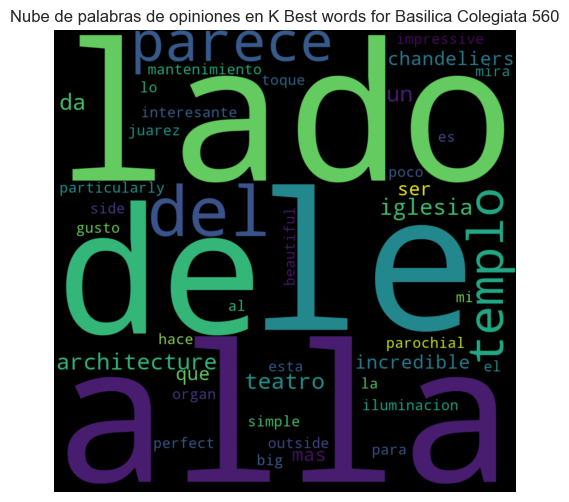

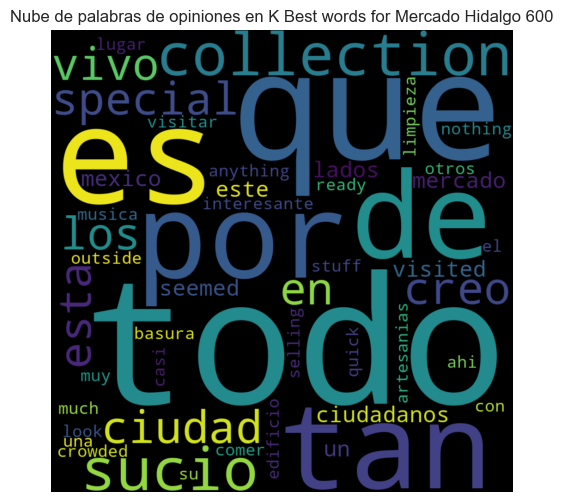

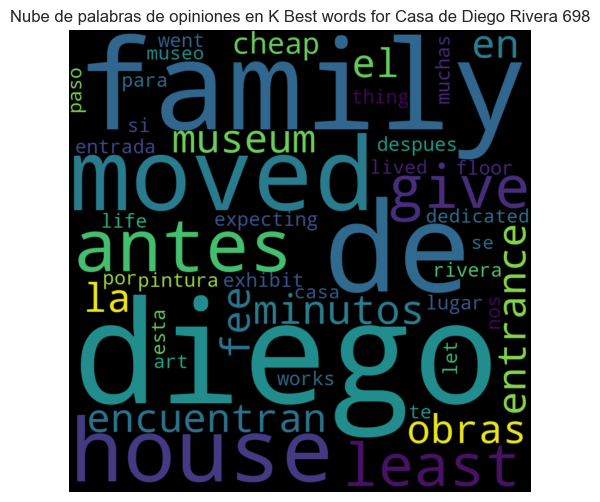

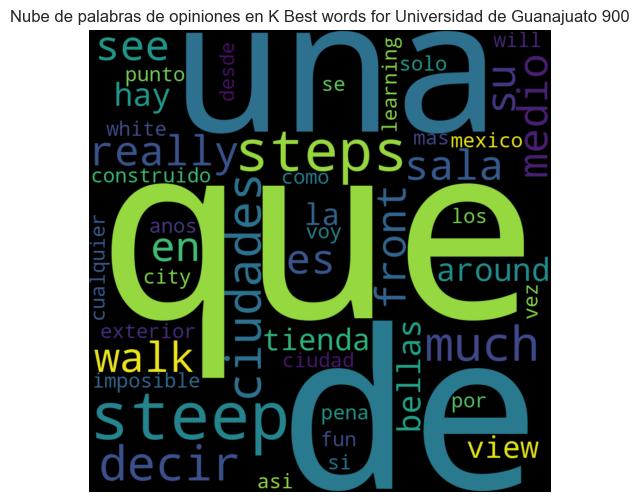

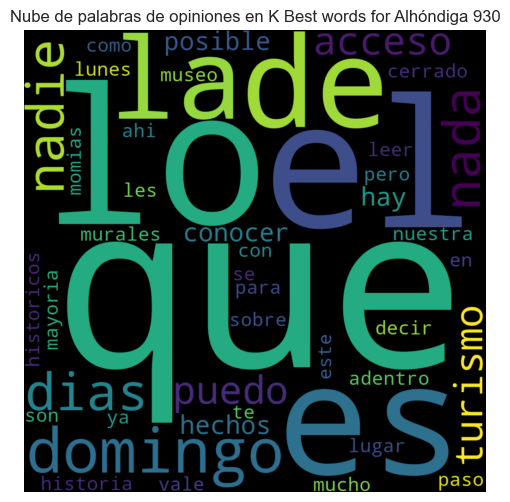

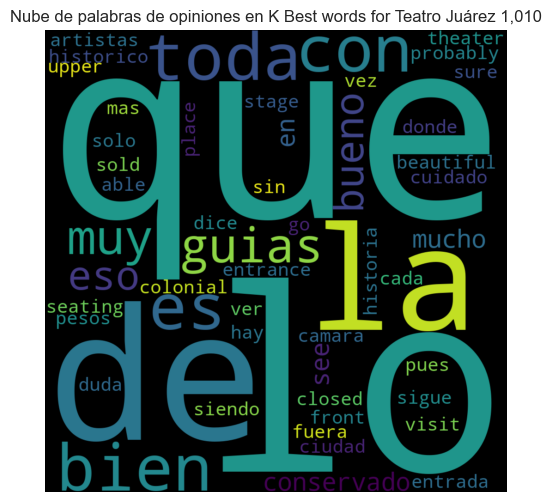

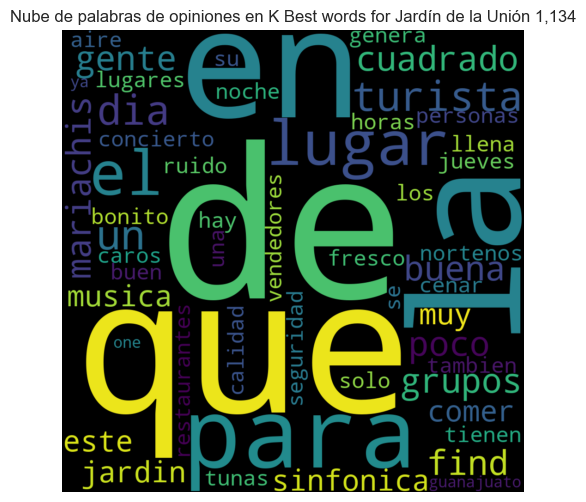

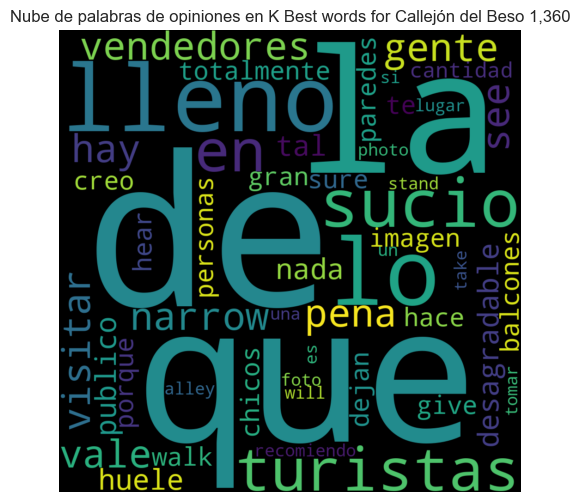

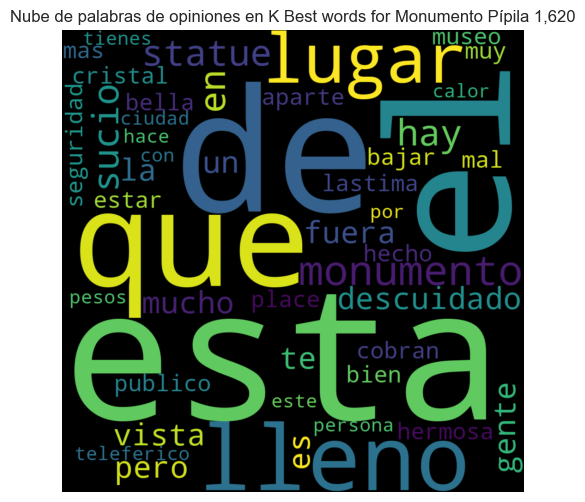

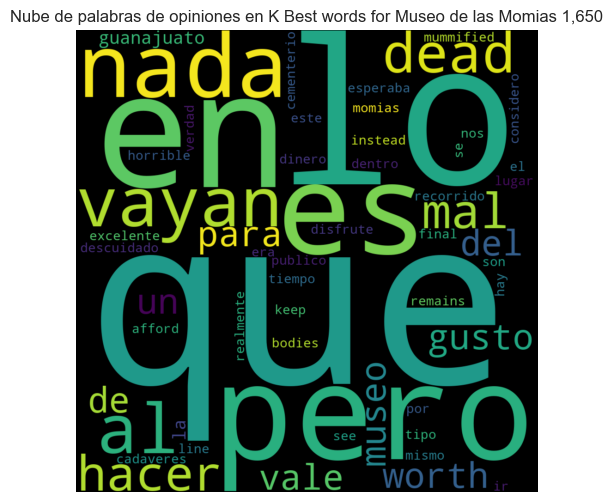

In [294]:
for sheet_name in sheet_names:

    df_aux = df_all[df_all['Ubicacion'] == sheet_name].copy()
    vectorizer = TfidfVectorizer(max_features=1000) 
    X_uni = vectorizer.fit_transform(df_aux['Opinion'].copy())
    # print(vectorizer.get_feature_names_out())
    vectorizer2 = TfidfVectorizer(ngram_range=(2,2), max_features=2000)
    X_bi = vectorizer2.fit_transform(df_aux['Opinion'].copy())
    # print(vectorizer2.get_feature_names_out())
    vectorizer3 = TfidfVectorizer(ngram_range=(3,3), max_features=1000)
    X_tri = vectorizer3.fit_transform(df_aux['Opinion'].copy())
    # print(vectorizer3.get_feature_names_out())
    # print(X_uni.shape, X_bi.shape, X_tri.shape)
    X = np.concatenate((X_uni.todense(), X_bi.todense(), X_tri.todense()), axis=1)
    feature_names = np.concatenate((vectorizer.get_feature_names_out(), vectorizer2.get_feature_names_out(), vectorizer3.get_feature_names_out()), axis=0)
    y = df_aux['Score']
    y = y.astype(int)
    # print(X.shape, y.shape)
    X = pd.DataFrame(X)
    # print(type(X), type(y), X.shape)

    # Select top 50 features
    selector = SelectKBest(chi2, k=50)
    selector.fit(X, y)
    # Get idxs of columns to keep
    idxs_selected = selector.get_support(indices=True)
    K_Best_words = ''
    for idx in idxs_selected:
        K_Best_words += feature_names[idx] + ' '
    plot_word_cloud(K_Best_words, title='K Best words for ' + sheet_name)

### 6. (10pts) Diseñe un análisis temporal (formato libre) que muestre opiniones positivas, negativas y neutras a través de los meses y años para todos los sitios turísticos. En pocas palabras mostrar la evolución de las opiniones a través del tiempo.

In [295]:
dates = df_all['Fecha']
years = []
for date in dates:
    date = date.split('-')
    year = date[0]
    years.append(year)
years = list(set(years))
# sort
years.sort()
print(years)

for year in years:
    df_aux = df_all[df_all['Fecha'].str.contains(str(year))].copy()
    print(year, df_aux.shape)    

['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
2002 (1, 14)
2003 (2, 14)
2004 (3, 14)
2005 (1, 14)
2006 (2, 14)
2007 (3, 14)
2008 (5, 14)
2009 (8, 14)
2010 (21, 14)
2011 (104, 14)
2012 (999, 14)
2013 (796, 14)
2014 (955, 14)
2015 (1947, 14)
2016 (2467, 14)
2017 (1844, 14)
2018 (588, 14)


In [296]:
years = [2011, 2014, 2015, 2017, 2018]

df_opiniones_by_year = []

for sheet_name in sheet_names:
    df_ubicacion = df_all[df_all['Ubicacion'] == sheet_name].copy()
    for year in years:
        df_aux_all = df_ubicacion[df_ubicacion['Fecha'].str.contains(str(year))].copy()
        
        phrases_positivas, phrases_negativas = [], []

        df_aux = df_aux_all[df_aux_all['Score'] <= 3]
        X, y = df_aux['Opinion'], df_aux['Score']
        if X.shape[0] > 2:
            y = y.astype(int)
            df_lsa, encoding_matrix, _, _ = apply_lsa(df_aux)
            phrases_negativas = df_aux['Opinion'].loc[df_aux['Opinion'].str.len().between(50, 500)].sample(2).values
            title = sheet_name + ' ' + str(year) +' Negativos'
            
        df_aux = df_aux_all[df_aux_all['Score'] > 3]
        X, y = df_aux['Opinion'], df_aux['Score']
        if X.shape[0] > 2:
            y = y.astype(int)
            df_lsa, encoding_matrix, _, _ = apply_lsa(df_aux)
            phrases_positivas = df_aux['Opinion'].loc[df_aux['Opinion'].str.len().between(50, 500)].sample(2).values
            title = sheet_name + ' ' + str(year) +' Negativos'
            
        df_opiniones_by_year.append([sheet_name, str(year), phrases_positivas[0] if len(phrases_positivas) > 0 else "", phrases_negativas[0] if len(phrases_negativas) > 0 else ""])
    
# to df 
df_opiniones_by_year = pd.DataFrame(df_opiniones_by_year, columns=['Ubicacion', 'Año', 'Opiniones Positivas', 'Opinion Negativas'])
df_opiniones_by_year.to_excel('opiniones_por_anio.xlsx', index=False)

display(df_opiniones_by_year)

Ubicacion   Año  \
0          Basilica Colegiata 560  2011   
1          Basilica Colegiata 560  2014   
2          Basilica Colegiata 560  2015   
3          Basilica Colegiata 560  2017   
4          Basilica Colegiata 560  2018   
5             Mercado Hidalgo 600  2011   
6             Mercado Hidalgo 600  2014   
7             Mercado Hidalgo 600  2015   
8             Mercado Hidalgo 600  2017   
9             Mercado Hidalgo 600  2018   
10       Casa de Diego Rivera 698  2011   
11       Casa de Diego Rivera 698  2014   
12       Casa de Diego Rivera 698  2015   
13       Casa de Diego Rivera 698  2017   
14       Casa de Diego Rivera 698  2018   
15  Universidad de Guanajuato 900  2011   
16  Universidad de Guanajuato 900  2014   
17  Universidad de Guanajuato 900  2015   
18  Universidad de Guanajuato 900  2017   
19  Universidad de Guanajuato 900  2018   
20                  Alhóndiga 930  2011   
21                  Alhóndiga 930  2014   
22                  Alhóndiga 930  2015   
23                  Alhóndiga 930  2017   
24                  Alhóndiga 930  2018   
25            Teatro Juárez 1,010  2011   
26            Teatro Juárez 1,010  2014   
27            Teatro Juárez 1,010  2015   
28            Teatro Juárez 1,010  2017   
29            Teatro Juárez 1,010  2018   
30       Jardín de la Unión 1,134  2011   
31       Jardín de la Unión 1,134  2014   
32       Jardín de la Unión 1,134  2015   
33       Jardín de la Unión 1,134  2017   
34       Jardín de la Unión 1,134  2018   
35        Callejón del Beso 1,360  2011   
36        Callejón del Beso 1,360  2014   
37        Callejón del Beso 1,360  2015   
38        Callejón del Beso 1,360  2017   
39        Callejón del Beso 1,360  2018   
40         Monumento Pípila 1,620  2011   
41         Monumento Pípila 1,620  2014   
42         Monumento Pípila 1,620  2015   
43         Monumento Pípila 1,620  2017   
44         Monumento Pípila 1,620  2018   
45      Museo de las Momias 1,650  2011   
46      Museo de las Momias 1,650  2014   
47      Museo de las Momias 1,650  2015   
48      Museo de las Momias 1,650  2017   
49      Museo de las Momias 1,650  2018   

                                  Opiniones Positivas  \
0   the inside of this church in plaza la paz is i...   
1   this is one of the larger basilica in guanajua...   
2   hermosa jamas en mi vida habia visto un estado...   
3   lugar muy colorido y no lo puedes dejar pasar ...   
4   retablos y nave decorada candelabros al estilo...   
5   if you are old enough to remember what shoppin...   
6   un lugar muy padre abajo tienen comida y el se...   
7   this is a great market with lots of fresh frui...   
8   un lugar grande y emblematico podras encontrar...   
9   if you like mexican food it starts in a main m...   
10  it was very interesting to see smaller drawing...   
11  great art by dr and others can be seen here an...   
12  esta atraccion es interesante por ser la casa ...   
13                                                      
14                                                      
15                                                      
16  this university is famous because of its beaut...   
17  quede verdaderamente fascinado con este lugar ...   
18  termino de construirse en el ano 1955 el edifi...   
19  the university of guanajuato is a centrally lo...   
20  well worth the visit precolumbian displays wer...   
21  i learned a lot about mexican history at this ...   
22  es un lugar magico ya que es parte de la histo...   
23  we know so little about mexican history and th...   
24  just seeing the inside of the alhondiga is wor...   
25  we went to the teatro for a cervantino perform...   
26  very nice remodeling job we would recommend se...   
27  este teatro es un icono de guanajuato esta en ...   
28  architecturally amazing inside and out really ...   
29  this is mexicos 3rd most beautiful theater onl...   
30  es un tipico lugar para pasear o estarse cuent...   
31  es

# 1 (50pts) Preguntas: Conteste lo más detallado posible lo siguiente, dando argumentos y conclusiones claras según su análisis previo. Cada respuesta entre 150 (mínimo) y 300 (máximo) palabras.

## 1. (10pts) ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de ello?


## 2. (10pts)  En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre turistas nacionales e internacionales?


## 3. (10pts) ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?


## 4. (10pts) ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?

## 5. (10pts) ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)